## **Emit - Visions: ISS Data Copilot**
**BY MAURIZIO NALETTO -REVISIONE NICOLO' MELIS** TESTER: DAVIDE FABIO PISANO

NOTEBOOK FORKED FROM https://github.com/nasa/EMIT-Data-Resources/blob/main/python/how-tos/How_to_use_EMIT_Quality_data.ipynb


# How to: Use EMIT Quality Data - Fixed by Copilot
#Google Colab Version, please use colab pro, it needs a lot of ram!




---

There are two quality layers associated with L2A Reflectance Product contained within the L2A Mask file. The `mask` variable contains 6 binary flag bands (1-5, 8) which should be excluded from analysis, and two data bands (6,7).

The second `band_mask` variable indicates whether or not any given wavelength of any given pixel is interpolated. Interpolation occurs either due to a focal plane array bad pixel, or from saturation. This data is provided as a packed unsigned integer array with 36 elements.

**Requirements:**
+ A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download EMIT data   
+ Selected the `emit_tutorials` environment as the kernel for this notebook.
  + For instructions on setting up the environment, follow the the `setup_instructions.md` included in the `/setup/` folder of the repository.  

**Learning Objectives**
+ How to build a mask using the quality flags from an EMIT L2A Mask file
+ How to build a mask by unpacking the `band_mask` data
+ How to apply the band and quality masks to another EMIT file.

First of All install libraries

In [ ]:
#Fixed earthaccess netCDF4

!pip install earthaccess
!pip install netCDF4
!pip install hvplot
!pip install spectral==0.23.1
!pip install rasterio

  Using cached earthaccess-0.6.1-py3-none-any.whl (54 kB)
  Using cached multimethod-1.10-py3-none-any.whl (9.9 kB)
  Using cached pqdm-0.2.0-py2.py3-none-any.whl (6.8 kB)
  Using cached python_cmr-0.9.0-py3-none-any.whl (11 kB)
  Using cached s3fs-2023.9.2-py3-none-any.whl (28 kB)
  Using cached tinynetrc-1.3.1-py2.py3-none-any.whl (3.9 kB)
  Using cached bounded_pool_executor-0.0.3-py3-none-any.whl (3.4 kB)
  Using cached aiobotocore-2.5.4-py3-none-any.whl (73 kB)
  Using cached fsspec-2023.9.2-py3-none-any.whl (173 kB)
  Using cached botocore-1.31.17-py3-none-any.whl (11.1 MB)
  Using cached aioitertools-0.11.0-py3-none-any.whl (23 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstalling urllib3-2.0.6:
      Successfully uninstalled urllib3-2.0.6
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
  

---

## 1. Using EMIT Quality Flag Data
Import the required Python libraries.

In [ ]:
# Import Packages
import os
import earthaccess #give error, fixed
import netCDF4 as nc #fixed
from osgeo import gdal
import numpy as np
import xarray as xr
import hvplot.xarray #fixed
import holoviews as hv


import sys



In [ ]:
!git clone https://github.com/nasa/EMIT-Data-Resources.git #cloning repo



Cloning into 'EMIT-Data-Resources'...
remote: Enumerating objects: 676, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 676 (delta 153), reused 147 (delta 141), pack-reused 446
Receiving objects: 100% (676/676), 59.15 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (388/388), done.


In [ ]:
#Hack to use gdrive

# add downloaded emit_tools.py from nasa emit-data-resources
sys.path.append('/content/EMIT-Data-Resources/python/modules')

# Ora puoi importare il modulo emit_tools
import emit_tools

Login to your NASA Earthdata account and create a `.netrc` file using the `login` function from the `earthaccess` library. If you do not have an Earthdata Account, you can create one [here](https://urs.earthdata.nasa.gov/home).

In [ ]:
#earthaccess.login(persist=True)

In [ ]:
# Google drive mount for your data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For this notebook we will download the files necessary using `earthaccess`. You can also access the data in place or stream it, but this can slow due to the file sizes. Provide URLs for an EMIT L2A Reflectance and L2A Mask.

In [ ]:
#urls = ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20220903T163129_2224611_012/EMIT_L2A_RFL_001_20220903T163129_2224611_012.nc',
#        'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20220903T163129_2224611_012/EMIT_L2A_MASK_001_20220903T163129_2224611_012.nc']
# Get Https Session using Earthdata Login Info
#fs = earthaccess.get_fsspec_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
#for url in urls:
#    granule_asset_id = url.split('/')[-1]
#    # Define Local Filepath
#    fp = f'../../data/{granule_asset_id}'
    # Download the Granule Asset if it doesn't exist#
#    if not os.path.isfile(fp):
 #       fs.download(url, fp)

Set a filepath for the reflectance and mask files downloaded.

In [ ]:


#USE DOWNLOADED FILES AND LOAD THEM FROM GDRIVE

fp = '/content/drive/MyDrive/EMIT FILES/EMIT_L2A_RFL_001_20230222T102312_2305307_006.nc' #PATH FILE GDRIVE
fp_mask = '/content/drive/MyDrive/EMIT FILES/EMIT_L2A_MASK_001_20230222T102312_2305307_006.nc' #PATH MASK FILE GDRIVE

The most efficient way to utilize the mask is to apply it before orthorectification because the orthorectified datasets take up more space. To apply a  mask using the L2A Mask file, we want to open it, specify which bands to use in construction of a mask, and then apply the mask.

To do this, first take a look at what each band will mask by reading in the `sensor_band_parameters` group from the mask file as an `xarray.dataset` then converting to a dataframe.

>Note: In the user guide, the bands are indexed as 1-8 not 0-7 as used here.

In [ ]:
mask_parameters_ds = xr.open_dataset(fp_mask,engine = 'h5netcdf', group='sensor_band_parameters')
mask_key = mask_parameters_ds['mask_bands'].to_dataframe()
mask_key

mask_bands
bands                    
0              Cloud flag
1             Cirrus flag
2              Water flag
3         Spacecraft Flag
4      Dilated Cloud Flag
5                  AOD550
6            H2O (g cm-2)
7          Aggregate Flag

# Visualizing the mask

Let's start by reviewing some of the content of these bands, and seeing what's available.

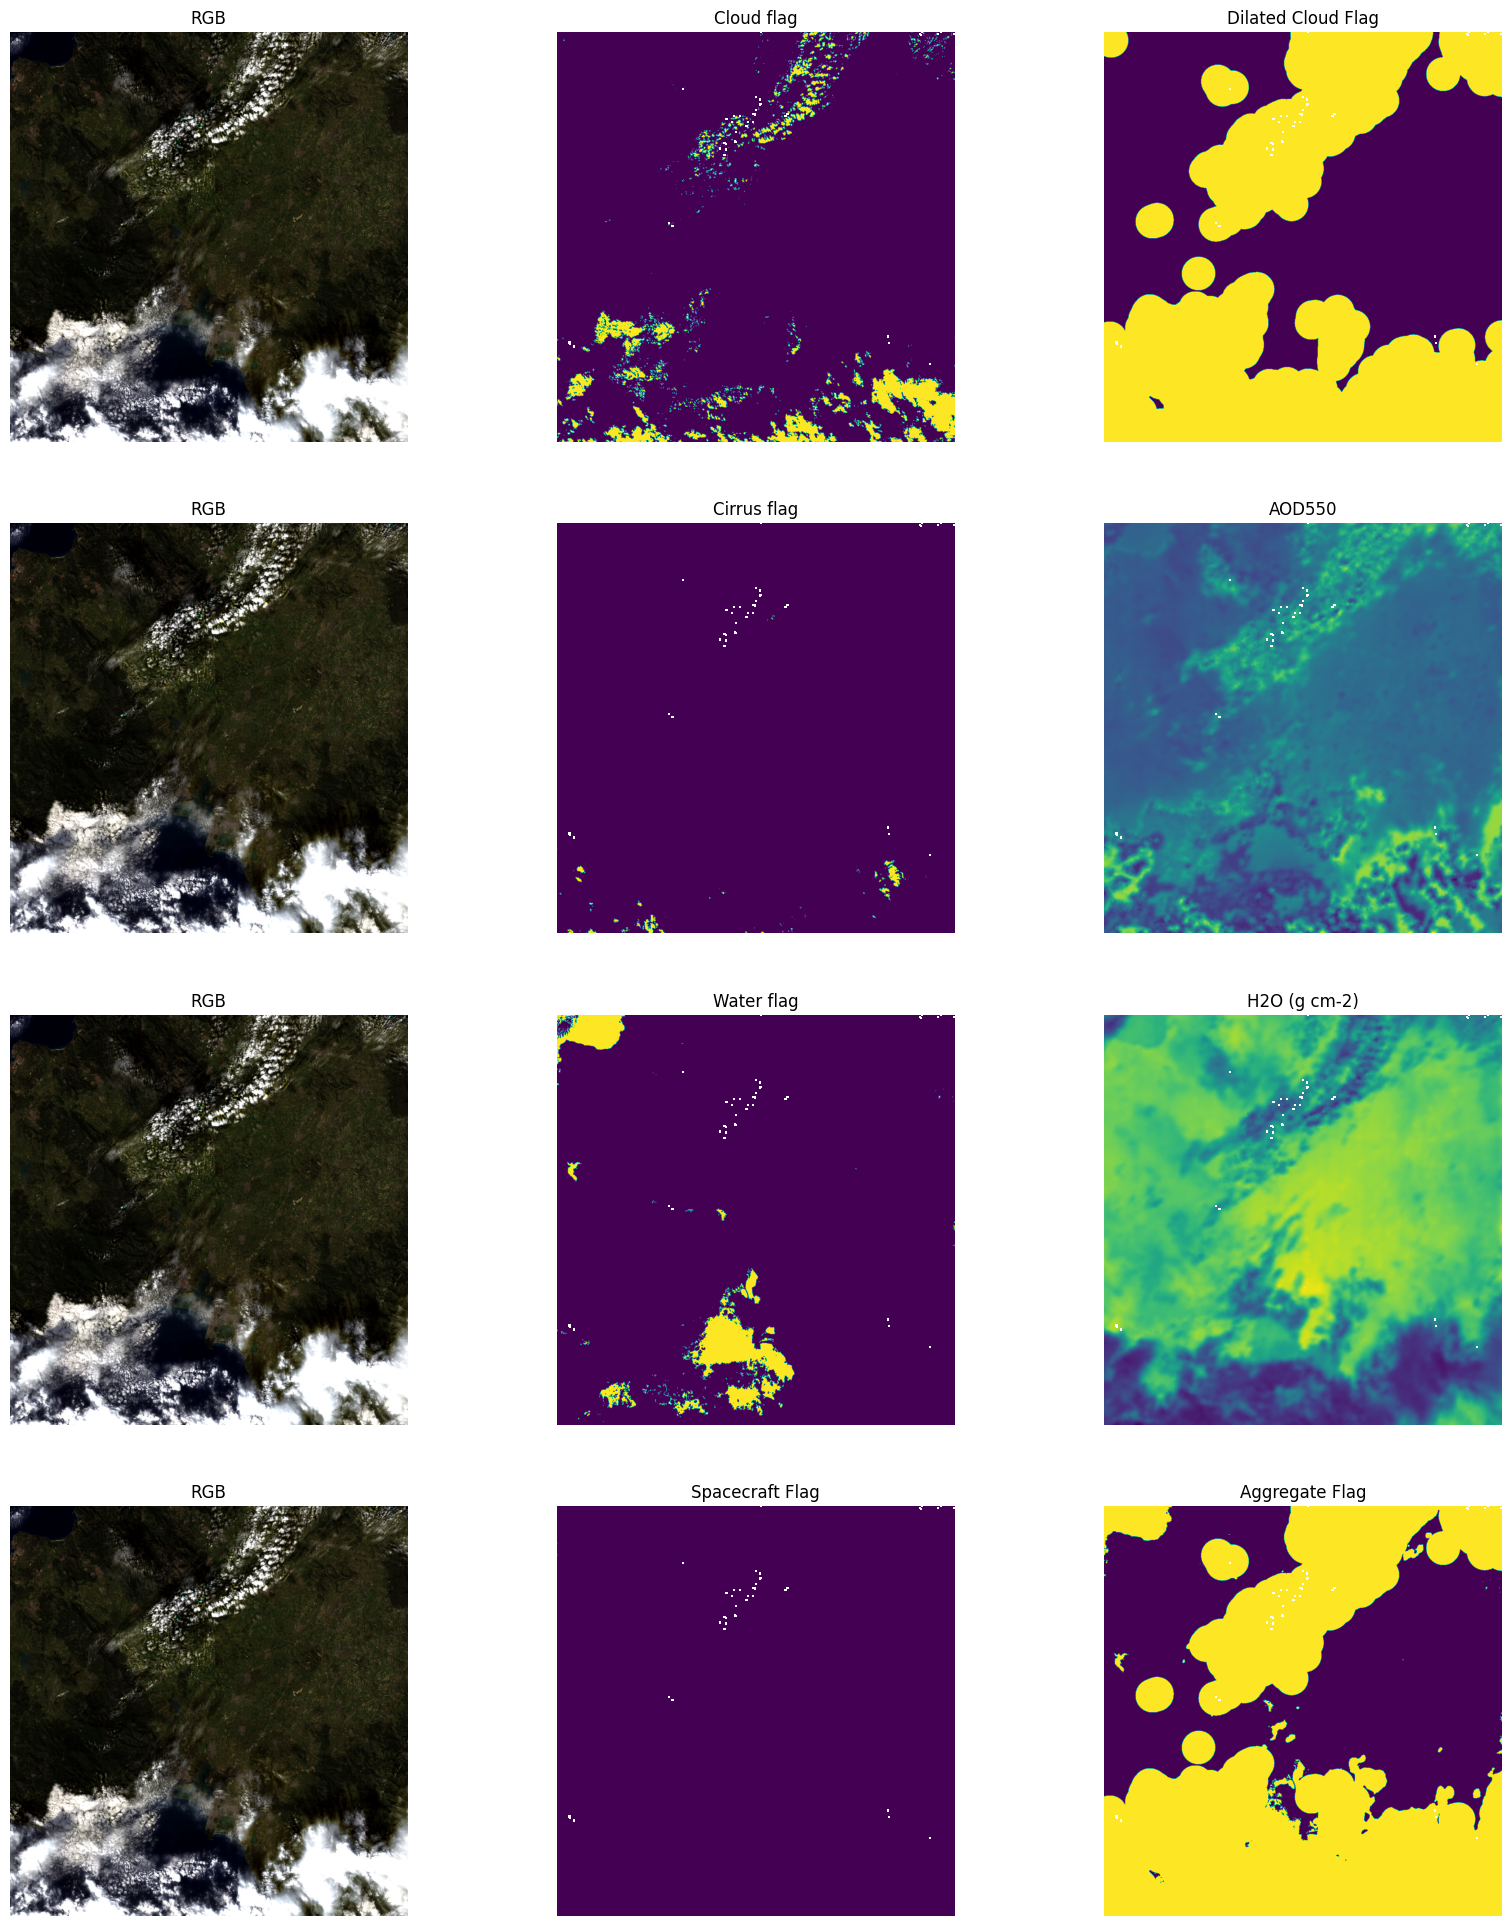

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,50))
gs = gridspec.GridSpec(ncols=3, nrows=len(mask_key), figure=fig)

ds = emit_tools.emit_xarray(fp, ortho = False)

mask_ds = emit_tools.emit_xarray(fp_mask, ortho=False)

rgb_inds = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [650, 560, 470]])
rgb = ds['reflectance'].values[:,:,rgb_inds] # subset RGB
rgb[rgb < 0] = np.nan
rgb -= np.nanpercentile(rgb,2,axis=(0,1))[np.newaxis,np.newaxis,:] # scale from 2-95 %
rgb /= np.nanpercentile(rgb,95,axis=(0,1))[np.newaxis,np.newaxis,:]

for _n in range(int(len(mask_key)/2)):
    ax = fig.add_subplot(gs[_n, 0])
    plt.imshow(rgb);
    plt.axis('off')
    plt.title('RGB')

    ax = fig.add_subplot(gs[_n, 1])
    md = mask_ds['mask'].values[...,_n]
    md[np.isnan(rgb[...,0])] = np.nan
    plt.imshow(md);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n])

    ax = fig.add_subplot(gs[_n, 2])
    md = mask_ds['mask'].values[...,_n+int(len(mask_key)/2)]
    md[np.isnan(rgb[...,0])] = np.nan
    plt.imshow(md);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n+int(len(mask_key)/2)])

Some of these bands are direct masks (Cloud, Dilated, Currus, Water, Spacecraft), and some (AOD550 and H2O (g cm-2)) are information calculated during the L2A reflectance retrieval that may be used as additional screening, depending on the application.  The final mask that the EMIT mission will use for its minerological applications is shown as the Aggreged Flag - but not all users might want this particular mask.

Let's take a closer look at some of those bands with additional information, that could be used either to screen specific content out or that might be used as signal:

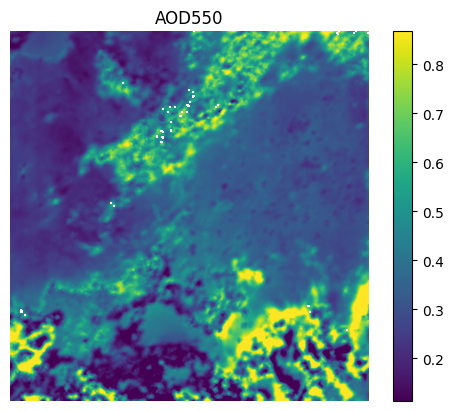

In [ ]:
fig = plt.figure()
md = mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('AOD550')]
md[np.isnan(rgb[...,0])] = np.nan
plt.imshow(md, vmin=np.nanpercentile(md,2),vmax=np.nanpercentile(md,98));
plt.title('AOD550') #remove title
plt.colorbar() #remove colorbar

#copy image plt
vmin = np.nanpercentile(md, 2)
vmax = np.nanpercentile(md, 98)

# Visualizza l'immagine
plt.imshow(md, vmin=vmin, vmax=vmax)


#plt.colorbar('off')
plt.axis('off') #remove axis bar
# Salva l'immagine in formato PNG
plt.savefig('AOD550.png', format='png')


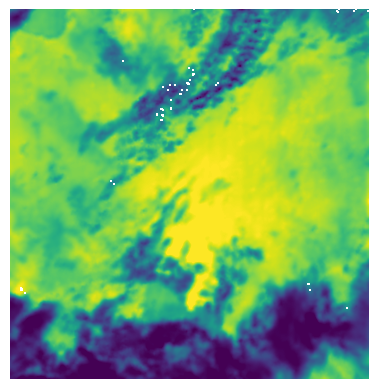

In [ ]:
fig = plt.figure()
md = mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('H2O (g cm-2)')]
md[np.isnan(rgb[...,0])] = np.nan
plt.imshow(md, vmin=np.nanpercentile(md,2),vmax=np.nanpercentile(md,98));
plt.axis('off') #remove axis bar
plt.savefig('h2o.png', format='png')
#plt.title('H2O (g cm-2)')
#plt.colorbar()

# Applying the Mask

In [ ]:
mask_key

mask_bands
bands                    
0              Cloud flag
1             Cirrus flag
2              Water flag
3         Spacecraft Flag
4      Dilated Cloud Flag
5                  AOD550
6            H2O (g cm-2)
7          Aggregate Flag

The above dataframe shows exactly what each band contained within the file represents/will mask. For this example we will use flags 0,1,3, and 4 to remove any potential clouds and any artefacts caused by the space station. This can be done using the `quality_mask` function from the `emit_tools` module. This function combines the requested flags into a single mask and returns it as an array.

Select the bands to use.

In [ ]:
flags = [0,1,3]
flags

[0, 1, 3]

Now create the mask using the `quality_mask` function.

In [ ]:
mask = emit_tools.quality_mask(fp_mask,flags)

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag']


To see the regions of the unorthocorrected image that will be masked we can plot the mask array.

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag' 'Dilated Cloud Flag']


Text(0, 0.5, 'Reflectance')

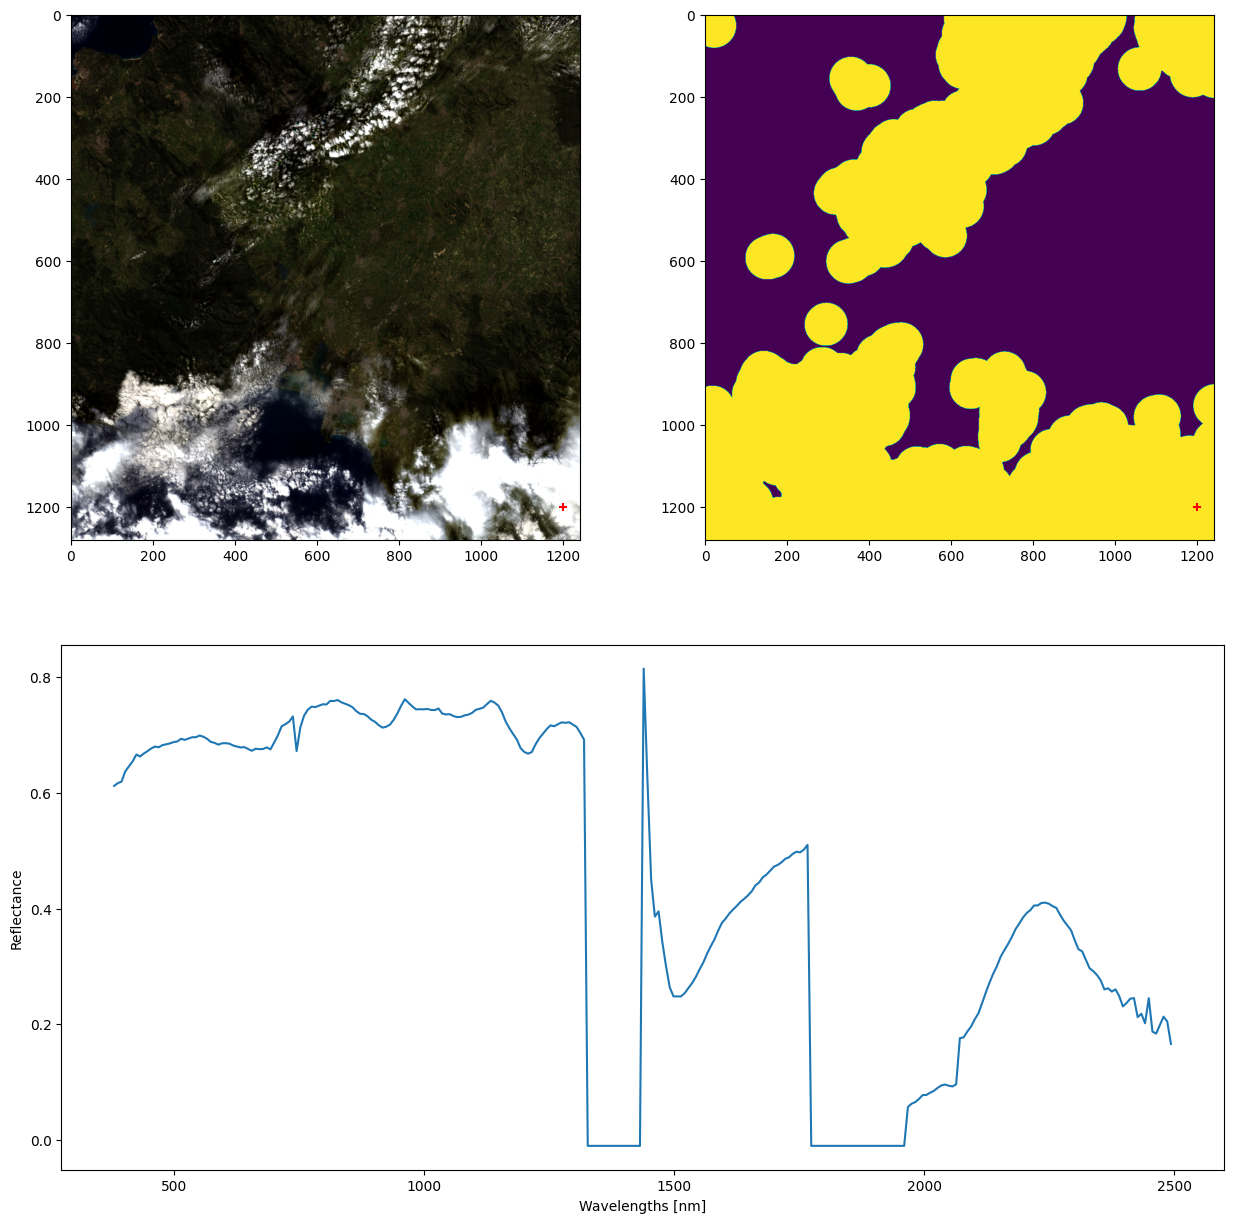

In [ ]:
flags = [0,1,3,4]
mask = emit_tools.quality_mask(fp_mask,flags)
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
plt.imshow(rgb)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[0, 1])
plt.imshow(mask)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[1, :])
plt.plot(ds['wavelengths'],ds['reflectance'].values[1200,1200,:])
plt.xlabel('Wavelengths [nm]')
plt.ylabel('Reflectance')

Now that we have a mask to apply, we can use it as the `qmask` parameter in the `emit_xarray` function.


## **EXTRACTING DATA - an low RAM mode, easy but rough approach WITHOUT Orthorectification - But if you have your data Orthorectificated, you could use your data and you will get precise infos, with this approach you could extract the percentage of a precise group of pixel colour range**

The Earth Surface Mineral Dust Source Investigation (EMIT) instrument measures surface mineralogy, targeting the Earth’s arid dust source regions. The measurements will then be used as input data for the composition of dust sources in Earth System Models (ESM). EMIT is installed on the International Space Station (ISS) and uses imaging spectroscopy to take mineralogical measurements of sunlit regions of interest between 52° N latitude and 52° S latitude. Up to five visits (three on average) of each arid target region are scheduled, only downlinking acquisitions that are not dominated by cloud cover. The EMIT instrument is an imaging spectrometer that uses contiguous spectroscopic measurements in the visible to shortwave infrared region of the spectrum to resolve absorption features of dust-forming minerals. EMIT has a viewing swath width of 75 km, measuring 285 bands at a spatial resolution of 60 m. Maps of the relative abundance of source minerals that are generated from EMIT data will advance our understanding of the current and future impacts of mineral dust in the Earth system. Learn more on the EMIT


Info from:
https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/emit-overview/#:~:text=EMIT%20has%20a%20viewing%20swath,dust%20in%20the%20Earth%20system.

BASICALLY EMIT SENSOR HAVE A SWAT WIDTH OF 75KM, in a rough mode you can measure the square meters of AOD550,	H2O (g cm-2) and also Clouds without orthorectification. This is a machine vision approach without using the high ram systems, very hard to obtain without high tech skills and resources (like a google colab student)

In [ ]:
!pip install opencv-python

% of white pixels 19.32%


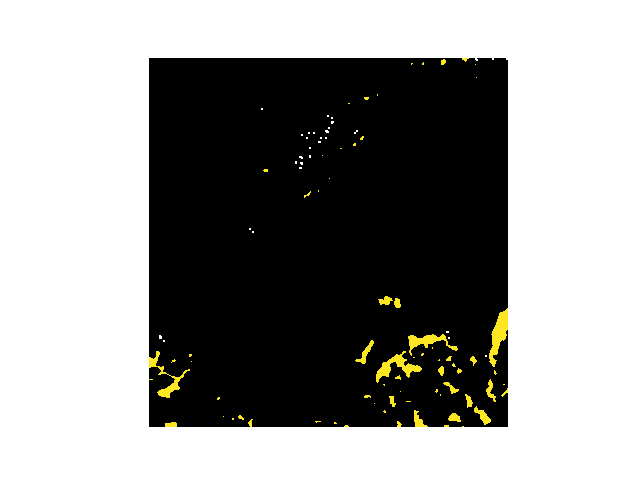

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow




# Carica l'immagine PNG
image = cv2.imread('/content/AOD550.png') #insert image here


# Assicurati che l'immagine sia stata letta correttamente
if image is not None:
    # Converte l'immagine in scala di grigio
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Trova i pixel bianchi nell'immagine
    white_pixels = cv2.inRange(gray_image, 205, 255)  # you can change this value

    # Calcola il numero totale di pixel nell'immagine
    total_pixels = image.size

    # Calcola la percentuale di pixel bianchi
    percentage_white = (cv2.countNonZero(white_pixels) / total_pixels) * 100

    print(f'% of white pixels {percentage_white:.2f}%')

    # Crea una maschera vuota
    mask = cv2.bitwise_and(image, image, mask=white_pixels)

    # Visualizza la maschera
    cv2_imshow(mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Impossible to read")



### We can quickly plot AOD550 or H20 Gr Cm2 pencentage in your image.




In [ ]:
#Rough Square meters of high percentage output.
# Define the side length of the square in meters (75 km)
side_length_km = 75
side_length_m = side_length_km * 1000  # Convert to meters

# Calculate the total area of the square in square meters
total_area_m2 = side_length_m ** 2

# Input: Percentage area (e.g., 20%)
percentage = percentage_white

# Calculate the area in square meters for the given percentage
percentage_area_m2 = (percentage / 100) * total_area_m2

print(f"Total Area: {total_area_m2} square meters")
print(f"Area for {percentage}%: {percentage_area_m2} square meters")

Total Area: 5625000000 square meters
Area for 19.31987847222222%: 1086743164.0625 square meters


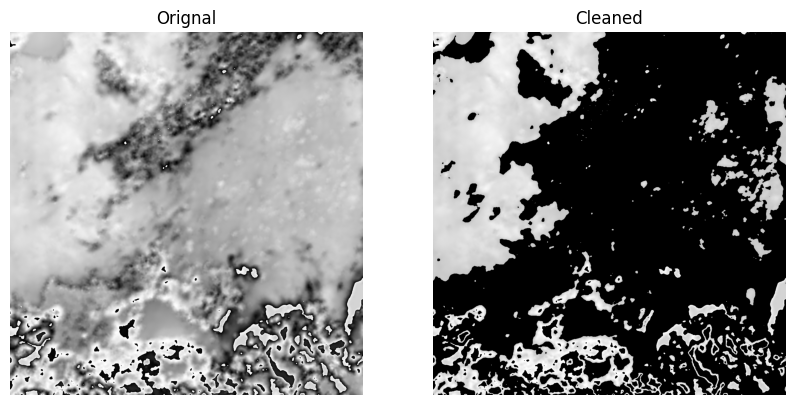

In [ ]:
import matplotlib.pyplot as plt

# Supponiamo di avere due immagini: image1 e image2
image1 = image

image2 = mask

# Crea una figura con due assi (due grafici affiancati)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostra la prima immagine sull'asse sinistro
axes[0].imshow(image1)
axes[0].set_title('Orignal')

# Mostra la seconda immagine sull'asse destro
axes[1].imshow(image2)
axes[1].set_title('Cleaned')

# Nascondi i margini dell'asse
for ax in axes:
    ax.axis('off')

# Mostra la figura
plt.show()


---
#Modified during NASA SPACE APPS 2023 - ISS COPILOT TEAM
## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 07-03-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  